In [1]:
from nilmtk.dataset_converters import convert_redd
convert_redd('../../data/redd/low_freq', '../../data/redd.h5')

In [12]:
import warnings; warnings.filterwarnings('ignore')

from nilmtk import DataSet
train = DataSet('../../data/redd.h5')
train.set_window(end="30-4-2011") #Use data only until 4/30/2011
train_elec = train.buildings[2].elec


In [13]:
train_elec.appliances

[Appliance(type='light', instance=1),
 Appliance(type='waste disposal unit', instance=1),
 Appliance(type='fridge', instance=1),
 Appliance(type='washer dryer', instance=1),
 Appliance(type='microwave', instance=1),
 Appliance(type='electric stove', instance=1),
 Appliance(type='dish washer', instance=1),
 Appliance(type='sockets', instance=1),
 Appliance(type='sockets', instance=2)]

In [14]:

from rnndisaggregator import RNNDisaggregator
rnn = RNNDisaggregator()

In [29]:

train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['sockets'] # The microwave meter that is used as a training target

rnn.train(train_mains, train_meter, epochs=5, sample_period=1)
rnn.export_model("model-redd5.h5")

Epoch 1/5
1031299/1031299 [==============================] - 726s 704us/step - loss: 2.9430e-04
Epoch 2/5
1031299/1031299 [==============================] - 858s 832us/step - loss: 6.0478e-05
Epoch 3/5
1031299/1031299 [==============================] - 763s 740us/step - loss: 4.5363e-05
Epoch 4/5
1031299/1031299 [==============================] - 789s 765us/step - loss: 3.9040e-05
Epoch 5/5
1031299/1031299 [==============================] - 764s 741us/step - loss: 3.5197e-05


In [6]:
test = DataSet('../../data/redd.h5')
test.set_window(start="30-4-2011")
test_elec = test.buildings[2].elec
test_mains = test_elec.mains().all_meters()[0]

disag_filename = 'disag-out.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
rnn.disaggregate(test_mains, output, train_meter, sample_period=1)

New sensible chunk: 90239
New sensible chunk: 79109
New sensible chunk: 14534


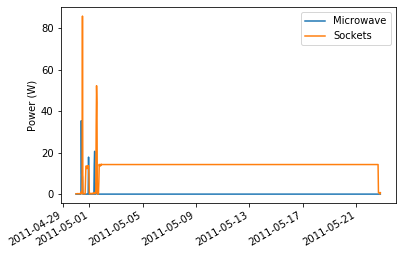

In [33]:

result = DataSet(disag_filename)
res_elec = result.buildings[2].elec
predicted = res_elec['microwave']
ground_truth = test_elec['sockets']

import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
plt.show()

In [9]:
import metrics
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

============ Recall: 0.014992289679593353
============ Precision: 0.744153082919915
============ Accuracy: 0.2457363497933435
============ F1 Score: 0.02939241675647683
============ Relative error in total energy: 0.7279952951006358
============ Mean absolute error(in Watts): 8.099625134199115


In [18]:
train_mains

[ElecMeter(instance=1, building=2, dataset='REDD', site_meter, appliances=[]),
 ElecMeter(instance=2, building=2, dataset='REDD', site_meter, appliances=[])]

In [30]:
res_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=2, dataset='LSTM', site_meter, appliances=[])
  ElecMeter(instance=11, building=2, dataset='LSTM', appliances=[Appliance(type='microwave', instance=1)])
)

In [ ]:
output.close()